# Homework 4 solution
- INFO 4871 / 5871
- Spring 2019
- Payoj Jain

## Objective (all students)
The object of this assignment is to gain familiarity with content-based recommendation algorithms. You will do this by implementing a simple hybrid recommender system and evaluating it relative to its components. I have provided the following:
- An outline of the NaiveBayesRecommender class. 
- A test case for the NaiveBayesRecommender class

You will first implement the NaiveBayesRecommender. It takes an item-feature table and produces a set of tables counting the user / feature / like (~like) combinations. 

Then you will use the algorithm to generate content-based recommendations for the MovieLens dataset using the "genre" values found in the movie table, and evaluate based on precision @ 10 compared to the item-item recommender.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Predictor, Recommender
from lenskit.algorithms.item_knn import ItemItem


## Import NaiveBayesRecommender
Use autoimport to support development of the NaiveBayes code

In [3]:
%load_ext autoreload
%aimport naive_bayes
%autoreload 2

from naive_bayes import NaiveBayesRecommender

In [4]:
import unittest
from test_naive_bayes import test_NaiveBayes

%aimport test_naive_bayes

### Running unit tests

In [5]:
suite = unittest.TestLoader().loadTestsFromTestCase(test_naive_bayes.test_NaiveBayes)
runner = unittest.TextTestRunner(verbosity=2)
runner.run(suite)

test_cond_prob (test_naive_bayes.test_NaiveBayes) ... ok
test_cond_tables (test_naive_bayes.test_NaiveBayes) ... ok
test_liked_prob (test_naive_bayes.test_NaiveBayes) ... ok
test_liked_tables (test_naive_bayes.test_NaiveBayes) ... ok
test_pred1 (test_naive_bayes.test_NaiveBayes) ... ok
test_pred2 (test_naive_bayes.test_NaiveBayes) ... ok
test_pred3 (test_naive_bayes.test_NaiveBayes) ... ok
test_recommend (test_naive_bayes.test_NaiveBayes) ... ok
test_reset (test_naive_bayes.test_NaiveBayes) ... ok
test_zeros (test_naive_bayes.test_NaiveBayes) ... ok

----------------------------------------------------------------------
Ran 10 tests in 0.612s

OK


<unittest.runner.TextTestResult run=10 errors=0 failures=0>

## Evaluation
Load ratings

In [6]:
ratings = pd.read_csv('ml_ratings.csv', encoding='latin1')
ratings = ratings.rename(columns={'userId': 'user', 'movieId': 'item'})
ratings = ratings.drop('timestamp', axis=1)
ratings.head()

,user,item,rating
0,12882,1,4.0
1,12882,32,3.5
2,12882,47,5.0
3,12882,50,5.0
4,12882,110,4.5


Load movie information

In [7]:
movies = pd.read_csv('ml_movies.csv', encoding='latin1')
movies = movies.rename(columns={'movieId': 'item', 'genres': 'feature'})
movies.head()

,item,title,feature
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Genre
Split out genres into a separate data frame with "Item", "Feature" columns.

In [8]:
from pandas import Series
new_movies = pd.DataFrame(movies['feature'].str.split('|').tolist(), index = movies.item).stack()
new_movies = new_movies.reset_index([0, 'item'])
new_movies.columns = ['item', 'feature']
new_movies.head()

,item,feature
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


## Instantiate algorithms
### Naive Bayes
Like / dislike threshold = 2.9
alpha = 0.01
beta = 0.02

In [9]:
naive = NaiveBayesRecommender(new_movies, thresh=2.9, alpha=0.01, beta=0.02)

### Item-based knn
neighbors = 20
minimum similarity = 0
center = True
aggregate = weighted-average

In [10]:
itemitem = ItemItem(20, min_sim=0, center=True, aggregate='weighted-average')

Supplied: eval_recs

In [11]:
def eval_recs(aname, fold, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    
    users = test.user.unique()
    recs = batch.recommend(fittable, users, 10)
    # add the algorithm
    recs['Algorithm'] = aname
    recs['Fold'] = fold
    return recs

5-fold cross-validation

In [12]:
np.random.seed(20190317)

all_recs1 = []
test_data1 = []
fold = 0
# 5 fold cross-validation
algorithm_type = [(naive,'Naive Bayes'), (itemitem,'ItemItem')]

for train, test in xf.partition_users(ratings[['user', 'item', 'rating']],5, xf.SampleFrac(0.2)):
    test_data1.append(test)
    for algo in algorithm_type:
        all_recs1.append(eval_recs(algo[1], fold, algo[0], train, test))
    
    print("Completed fold {}".format(fold))
    fold += 1

Completed fold 0
Completed fold 1
Completed fold 2
Completed fold 3
Completed fold 4


Put answers together

In [13]:
all_recs1 = pd.concat(all_recs1, ignore_index=True)
test_data1 = pd.concat(test_data1, ignore_index=True)

In [14]:
all_recs1.head()

,item,score,user,rank,Algorithm,Fold
0,2142,14.767065,359,1,Naive Bayes,0
1,1907,11.333452,359,2,Naive Bayes,0
2,48,11.008822,359,3,Naive Bayes,0
3,783,11.008822,359,4,Naive Bayes,0
4,364,10.940796,359,5,Naive Bayes,0


Run evaluation with precision

In [15]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.precision)

byuser_results = all_recs1.groupby(['Algorithm', 'Fold']).apply(lambda df: rla.compute(df, test_data1))
precision_per_fold = byuser_results.groupby(['Algorithm','Fold']).mean()
precision_per_fold_per_algorithm = precision_per_fold.groupby(['Algorithm']).agg([np.mean, np.std])

In [16]:
precision_per_fold_per_algorithm

precision          
                 mean       std
Algorithm                      
ItemItem     0.117266  0.010401
Naive Bayes  0.040835  0.003098

Plot using a bar chart with error bars as in Homework 3

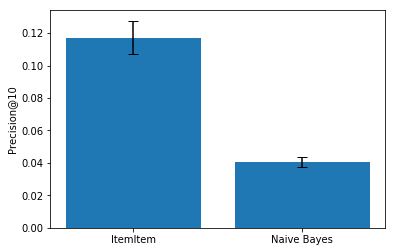

In [17]:
plt.bar(precision_per_fold_per_algorithm.index, precision_per_fold_per_algorithm['precision','mean'], yerr=precision_per_fold_per_algorithm['precision', 'std'], capsize=5)
plt.ylabel('Precision@10')
plt.show()

### Question
You can see that the content-based recommender has lower precision@10 than the collaborative one. Do you think that a weighted hybrid of these two methods would be better than the collaborative one alone? Justify your answer.

### Answer
> ItemItem based collaborative filtering looks at the ratings of the items which are in the neighbourhood and make recommendations while naive bayes looks at the content/feature of items and recommend similar items to users. Weighted hybrid model will contain both the properties of collaborative and content based recommendation.  
Hence, it would perform better than just the collaborative one alone. This can be explained by an example. Suppose Alice likes item 1 and item 3. Item 7 is similar to item 1 based on their content. It's highly probable that Alice will also like Item 7. Similarly, item 9 and item 3 are similar based on their content, so Alice might like item 9 too. Collaborative filtering may not be able to recommend item 7 and item 9 to Alice even though they should be in the recommendation.

## Using tags as content (INFO 5871)
Here you will use the same implementation as above, but you will use a different set of content data -- the tags from `ml_tags.csv`.

In [18]:
tags = pd.read_csv('ml_tags.csv', encoding='latin1')
tags.head()

,movieId,userId,tag,timestamp
0,3916,12882,sports,1147195545
1,4085,12882,Eddie Murphy,1147195966
2,33660,12882,boxing,1147195514
3,1197,320,must show,1145964801
4,1396,320,must show,1145964810


Calculate entropy of tag collection

$e_{tag} = - p_{tag} \log_{2} p_{tag}$

$p_{tag}$ = count of tag occurence / number of tagging events

In [19]:
tag_events = tags['tag'].count()
tag_events

94875

In [20]:
tag_counts = pd.DataFrame(tags.groupby('tag').count().userId)
tag_counts = tag_counts.rename(columns={'userId':'count'})
tag_counts.head()

,count
tag,
"""A MÃ£o-de-Deus""",1
"""Duck and cover!""",1
"""I need a computer.""",1
"""The Hunter""",1
"""bitchy""",1


In [21]:
tag_counts['prob'] = tag_counts['count']/tag_events
tag_counts['entropy'] = -tag_counts['prob']*np.log2(tag_counts['prob'])
tag_counts.head()

,count,prob,entropy
tag,,,
"""A MÃ£o-de-Deus""",1,0.000011,0.000174
"""Duck and cover!""",1,0.000011,0.000174
"""I need a computer.""",1,0.000011,0.000174
"""The Hunter""",1,0.000011,0.000174
"""bitchy""",1,0.000011,0.000174


Drop tags with entropy <= 0.001. (There aren't tags with high entropy, so we won't filter for that.)

In [22]:
tag_counts = tag_counts[tag_counts.entropy > 0.001]
tag_counts.head()

,count,prob,entropy
tag,,,
"""damn dirty apes""",11,0.000116,0.001516
*Good* Musicals,7,0.000074,0.001013
007,44,0.000464,0.005136
007 (series),29,0.000306,0.003569
1,13,0.000137,0.001758


Use this set of tags to filtering the original tag data so that it only includes the tags with higher entropy.

In [23]:
filtered = tags.join(tag_counts, on = 'tag', how='right')
filtered = filtered.reset_index()
filtered.head()

,index,movieId,userId,tag,timestamp,count,prob,entropy
0,0,3916,12882,sports,1147195545,121,0.001275,0.012262
1,3519,72641,113540,sports,1339627146,121,0.001275,0.012262
2,4166,524,12778,sports,1137526683,121,0.001275,0.012262
3,4229,1302,12778,sports,1137528275,121,0.001275,0.012262
4,4278,2409,12778,sports,1137529133,121,0.001275,0.012262


Convert filtered tag data to collection of features for the content-based recommender

In [24]:
tag_features = pd.DataFrame({'item':filtered['movieId'], 'feature':filtered['tag']})

In [25]:
tag_features.head()

,item,feature
0,3916,sports
1,72641,sports
2,524,sports
3,1302,sports
4,2409,sports


Create the NaiveBayesRecommender with these features. thresh=2.9, alpha=0.01, beta=0.02

In [26]:
naive_tag = NaiveBayesRecommender(tag_features, thresh=2.9, alpha=0.01, beta=0.02)

Run the evaluation

In [27]:
np.random.seed(20190317)

all_recs2 = []
test_data2 = []
fold = 0
# Evaluation code here
for train, test in xf.partition_users(ratings, 5, xf.SampleFrac(0.2)):
    test_data2.append(test)
    all_recs2.append(eval_recs('Tags', fold, naive_tag, train, test))
    print("Completed fold {}".format(fold))
    fold += 1

Completed fold 0
Completed fold 1
Completed fold 2
Completed fold 3
Completed fold 4


Assemble the results data

In [28]:
all_recs2 = pd.concat(all_recs2, ignore_index=True)
test_data2 = pd.concat(test_data2, ignore_index=True)

Compute precision at 10.

In [29]:
rla2 = topn.RecListAnalysis()
rla2.add_metric(topn.precision)

byuser_results2 = all_recs2.groupby(['Algorithm', 'Fold']).apply(lambda df: rla2.compute(df, test_data2))
precision_per_fold2 = byuser_results2.groupby(['Algorithm','Fold']).mean()
precision_per_fold_per_algo2 = precision_per_fold2.groupby(['Algorithm']).agg([np.mean, np.std])

In [30]:
precision_per_fold_per_algo2

precision          
               mean       std
Algorithm                    
Tags       0.212771  0.008447

Combine with the results from part 1

In [31]:
results = pd.concat([precision_per_fold_per_algorithm, precision_per_fold_per_algo2])
results

precision          
                 mean       std
Algorithm                      
ItemItem     0.117266  0.010401
Naive Bayes  0.040835  0.003098
Tags         0.212771  0.008447

Plot all three results as a bar plot with error bars.

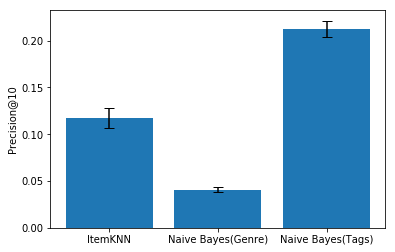

In [32]:
plt.bar(['ItemKNN','Naive Bayes(Genre)', 'Naive Bayes(Tags)'], results['precision','mean'], yerr=results['precision', 'std'], capsize=5)
plt.ylabel('Precision@10')
plt.show()

### Question
You will see that the tags form a better basis for content-based recommendation than the genre data and even better than the collaborative recommender. Why do you think this is the case here when the genre-based method was not as good? 

### Answer
> The assumption that the features are independent in naive bayes makes its performance low. From the above plot, its evident that Genres are more dependent and assuming them as indepedent features cost the performance of the model. While Tags on the other hand are more specific to items and independent of each other. Hence, naive bayes has a higher precision for Tags over Genres. 

> Item based collaborative filtering looks at the ratings of items. If an item is not been rated at all, item based collaborative filtering will not recommend that item to the user. This gives edge to the content based recommender system. Tags as features give good estimation of the content and thus, performs better. 